# Predict grain size from wireline logs

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datetime, os

import sklearn
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, max_error, median_absolute_error

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.6.0


### Get the data
First download and import the dataset using pandas:

In [4]:
df3 = pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/OS2_Merged_dataset_imputed_08_23_2021.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
raw_dataset = df3

In [6]:
raw_dataset2 = raw_dataset[['CAL', 'GR', 'DT','SP','DENS','PE','RESD',
                            'PHIN','PHID','GR_smooth','PE_smooth', 'gz_pchip_interp']]

In [7]:
dataset = raw_dataset2.copy()
dataset.tail()

,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,GR_smooth,PE_smooth,gz_pchip_interp
12025,0.080749,0.763390,0.318322,0.502314,0.628529,0.428994,-0.163882,0.378053,0.378053,0.766522,0.471810,4.3658
12026,0.080822,0.767160,0.319374,0.501919,0.636449,0.432019,-0.152552,0.369177,0.369177,0.767302,0.477121,6.7092
12027,0.080896,0.769669,0.321289,0.501597,0.647342,0.435815,-0.141083,0.360357,0.360357,0.768093,0.482966,6.7313
12028,0.080966,0.770943,0.323205,0.501896,0.659338,0.439788,-0.129482,0.351481,0.351481,0.768893,0.489439,4.3273
12029,0.081035,0.771780,0.325120,0.502990,0.671133,0.442261,-0.117661,0.342605,0.342605,0.769668,0.496650,4.3109


### Clean the data

The dataset contains a few unknown values.

In [8]:
dataset.isna().sum()

CAL                0
GR                 0
DT                 0
SP                 0
DENS               0
PE                 0
RESD               0
PHIN               0
PHID               0
GR_smooth          0
PE_smooth          0
gz_pchip_interp    0
dtype: int64

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our models.

In [9]:
train_dataset = dataset.sample(frac=0.75, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. Looking at the other rows it should be clear that they are each functions of eachother.

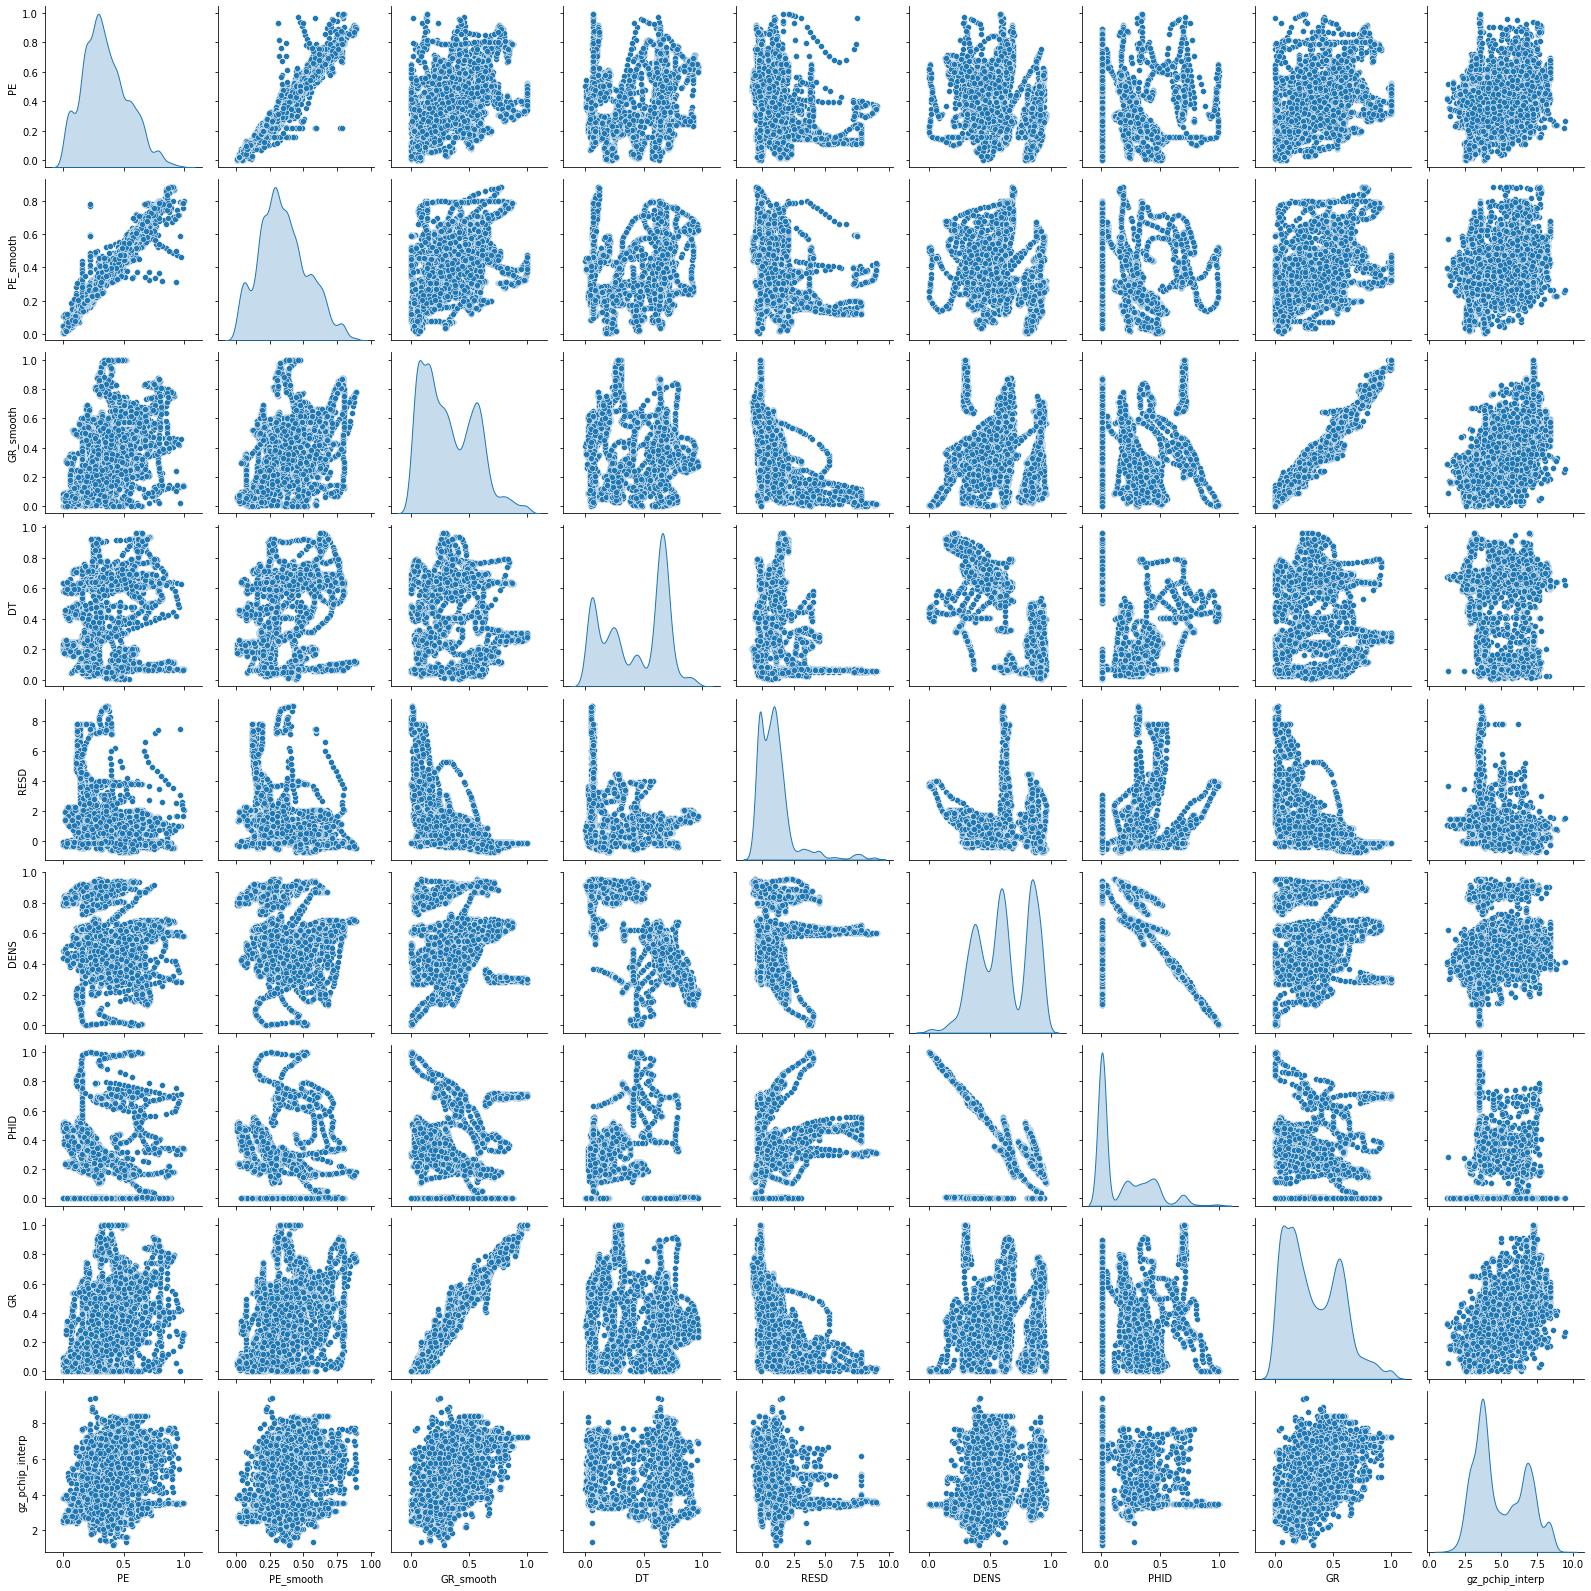

In [10]:
sns.pairplot(train_dataset[['PE', 'PE_smooth', 'GR_smooth', 
                            'DT', 'RESD','DENS','PHID', 'GR','gz_pchip_interp']], diag_kind='kde')

Also look at the overall statistics, note how each feature covers a very different range:

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,9022.0,0.468120,0.193755,0.000000,0.365169,0.557183,0.602663,0.893965
GR,9022.0,0.329142,0.236362,0.000000,0.128181,0.274936,0.528637,1.000000
DT,9022.0,0.430528,0.263506,0.003880,0.174029,0.474997,0.662938,0.963093
SP,9022.0,0.811721,0.157603,0.039257,0.747078,0.863855,0.924029,0.999890
DENS,9022.0,0.613765,0.213627,0.000702,0.423621,0.604916,0.830799,0.955384
PE,9022.0,0.350110,0.187005,0.000000,0.214331,0.324110,0.468850,0.997215
RESD,9022.0,1.014848,1.478676,-0.744314,-0.044070,0.807690,1.397011,9.019425
PHIN,9022.0,0.169740,0.222552,0.000570,0.004600,0.005520,0.333778,1.000000
PHID,9022.0,0.169740,0.222552,0.000570,0.004600,0.005520,0.333778,1.000000
GR_smooth,9022.0,0.329001,0.228426,0.000258,0.138207,0.285149,0.520268,1.000000


### Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [12]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('gz_pchip_interp')
test_labels = test_features.pop('gz_pchip_interp')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [13]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
CAL,0.468120,0.193755
GR,0.329142,0.236362
DT,0.430528,0.263506
SP,0.811721,0.157603
DENS,0.613765,0.213627
PE,0.350110,0.187005
RESD,1.014848,1.478676
PHIN,0.169740,0.222552
PHID,0.169740,0.222552
GR_smooth,0.329001,0.228426


It is good practice to normalize features that use different scales and ranges. 

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable. 

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [14]:
normalizer = preprocessing.Normalization()

Then `.adapt()` it to the data:

In [15]:
normalizer.adapt(np.array(train_features))

This calculates the mean and variance, and stores them in the layer. 

In [16]:
print(normalizer.mean.numpy())

[[0.468 0.329 0.431 0.812 0.614 0.35  1.015 0.17  0.17  0.329 0.35 ]]


When the layer is called it returns the input data, with each feature independently normalized:

In [17]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 0.59  0.8   0.64  0.93  0.67  0.8  -0.08  0.    0.    0.78  0.8 ]]

Normalized: [[ 0.64  2.    0.8   0.74  0.26  2.4  -0.74 -0.74 -0.74  1.97  2.5 ]]


### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [18]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [19]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu', # 64, 128, 256 (a step too far?)
                   activity_regularizer=tf.keras.regularizers.L2(0.01)), 
      layers.Dropout(.3),
      layers.Dense(64, activation='relu',  # 128, 256, 512
                   activity_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01)), 
      layers.Dense(1)
  ])

  model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Full model

If you repeat this process using all the inputs it slightly improves the performance on the validation dataset.

In [20]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 11)                23        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                384       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,584
Trainable params: 2,561
Non-trainable params: 23
_________________________________________________________________


In [21]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=200, 
    callbacks=[early_stop])

CPU times: user 1min 8s, sys: 6.86 s, total: 1min 15s
Wall time: 56 s


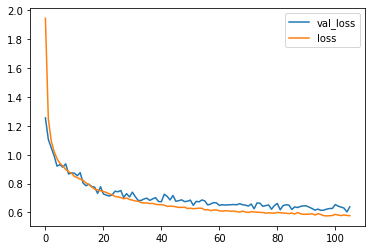

In [22]:
 plt.figure(figsize=(6,4))
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label='loss')
plt.legend()

In [23]:
(mean_squared_error(np.array(history.history['loss']), (history.history['val_loss'])))

0.006469684624822653

(-0.2, 0.2)

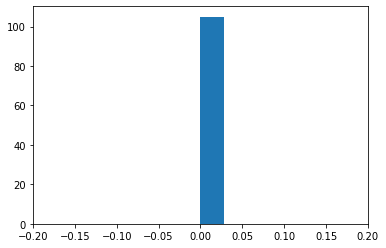

In [24]:
plt.hist((np.array(history.history['loss'])-np.array(history.history['val_loss']))**2, bins=17)
plt.xlim(-0.2, 0.2)


Collect the results on the test set:

In [25]:
dnn_model.evaluate(test_features, test_labels, verbose=0)

0.610569953918457

## Performance

Now that all the models are trained check the test-set performance and see how they did:

These results match the validation error seen during training.

### Make predictions

Finally, predict have a look at the errors made by the model when making predictions on the test set:

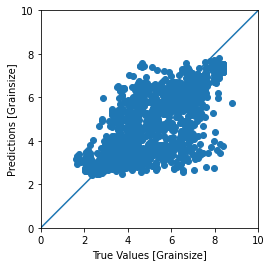

In [26]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Grainsize]')
plt.ylabel('Predictions [Grainsize]')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It looks like the model predicts reasonably well. 

Now take a look at the error distribution:

In [27]:
rmse5 = mean_squared_error(test_labels, test_predictions, squared=False)
print("Mean Squared Error: %f" % (rmse5))

max5 = max_error(test_labels, test_predictions)
print("Max Error: %f" % (max5))

MAE = median_absolute_error(test_labels, test_predictions)
print("Median Absolute Error: %f" % (MAE))

Mean Squared Error: 0.917083
Max Error: 5.206510
Median Absolute Error: 0.288405


# Export

In [28]:
x = datetime.datetime.now()

d = {'target': ['gz'],
     'MSE': [rmse5],
     'MAE':[MAE],
     'MaxError': [max5], 
     'day': [x.day], 
     'month':[ x.month], 
     'year':[x.year],
     'model':['DNN'],
     'version':[tf.__version__]}

results = pd.DataFrame(data=d)

results.to_csv('drive/My Drive/1_lewis_research/analysis/experiments/dnn/dnn_results/OS2_grainsize_DNN.csv')

results

,target,MSE,MAE,MaxError,day,month,year,model,version
0,gz,0.917083,0.288405,5.20651,25,8,2021,DNN,2.6.0


(-6.0, 6.0)

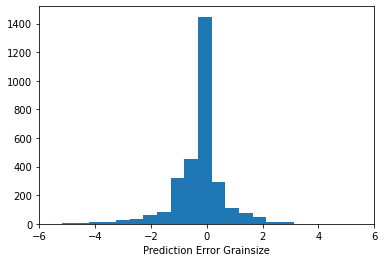

In [29]:
error = test_predictions - test_labels
plt.hist(error, bins=17)
plt.xlabel('Prediction Error Grainsize')
plt.xlim((-6,6))

If you're happy with the model save it for later use:

In [30]:
dnn_model.save('dnn_model.h5')

If you reload the model, it gives identical output:

In [31]:
#reloaded = tf.keras.models.load_model('dnn_model')

#test_results['reloaded'] = reloaded.evaluate(
#    test_features, test_labels, verbose=0)